In [194]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Настройки Pandas
pd.set_option('display.max_columns', None)

In [195]:
# Чтение датасета
df = pd.read_csv('/Users/stanislawtsurkan/ds_bootcamp/rent-real-estate/data/_data.csv')

In [196]:
# Удаляем столбец `Unnamed: 0`
df = df.iloc[:, 1:]

# Переименовываем столбцы
NEW_COLUMNS = {
    'ID  объявления':           'id',
    'Количество комнат':        'rooms',
    'Тип':                      'type',
    'Метро':                    'metro_station',
    'Адрес':                    'address',
    'Площадь, м2':              'area',
    'Дом':                      'building_type',
    'Парковка':                 'parking',
    'Цена':                     'price',
    'Телефоны':                 'phones',
    'Описание':                 'description',
    'Ремонт':                   'renovation',
    'Площадь комнат, м2':       'rooms_area',
    'Балкон':                   'balcony',
    'Окна':                     'windows',
    'Санузел':                  'bathroom',
    'Можно с детьми/животными': 'kids_pets',
    'Дополнительно':            'extra',
    'Название ЖК':              'complex_title',
    'Серия дома':               'building_series',
    'Высота потолков, м':       'ceiling_height',
    'Лифт':                     'elevator',
    'Мусоропровод':             'trash_chute',
    'Ссылка на объявление':     'listing_url',
}
df = df.rename(columns=NEW_COLUMNS)

In [197]:
# исключим из исходного датасета г. Санкт-Петербург
df = df[~df["address"].str.contains('етербург')]

### Колонка `rooms`

In [198]:
# Создаем столбец `num_rooms` с кол-ом комнат
df['num_rooms'] = df['rooms'].str.extract(r'(\d+)').astype('Int64')

### Колонка `metro_station`

In [199]:
def extract_numbers(metro_station):
    if isinstance(metro_station, str): #проверяем на отсутствие Nun
        match = re.search(r'\d+', metro_station) #узнаем числа в ячейке
        if match:
            return int(match.group(0))
    return np.nan
df['time_to_metro'] = df['metro_station'].apply(extract_numbers)
mean_value = round(df['time_to_metro'].mean())
df['time_to_metro'].replace('', mean_value, inplace=True)

In [200]:
# Выделим из колонки `metro_station` сведения о времени до метро
pattern = r"\((\d+)\s*мин"
minutes_str = df['metro_station'].str.extract(pattern, expand=False)
df['time_to_metro'] = pd.to_numeric(minutes_str, errors="coerce")

### Колонка `area`

In [201]:
# Добавляем столбец с общей площадью квартир
df['total_area'] = df['area'].str.split('/').str[0].astype('float')

### Колонка `building_type`

In [202]:
# Добавляем столбец `floor` с номером этажа и `total_floors` с этажностью здания
df['floor'] = df['building_type'].str.extract(r'(\d{1,3})/').astype('Int64')
df['total_floors'] = df['building_type'].str.extract(r'/(\d{1,3})').astype('Int64')
df['parking'].unique()

array(['подземная', nan, 'наземная', 'открытая', 'многоуровневая',
       'на крыше'], dtype=object)

### Колонка `parking`

In [203]:
# категоризовываем колонку `parking` в колонку `parking_categories` от 0 до 5
df['parking'].fillna('нет', inplace=True)
df['parking_categories'] = pd.factorize(df['parking'])[0]

### Столбец `Price`

In [204]:
# Создаем столбец с главной ценой
# r'([\d\.]+)' Это регулярное выражение, которое используется для поиска чисел с точкой. 
# \d — означает любую цифру от 0 до 9. 
# [\d\.]+ — это: «одна или больше цифр и/или точек подряд». 
df['main_price'] = df['price'].str.extract(r'([\d\.]+)').astype(float)

# Поработаем с залогом
# Ищем слово Залог, дефис, и число после него
# *-\s* это мы так страхуемся, чтобы захватились пробелы до и после дефиса"""
df['deposit'] = df['price'].str.extract(r'Залог\s*-\s*([\d\s]+)')[0]
df['deposit'] = df['deposit'].str.replace(' ', '').astype(float).fillna(0)

# Коммунальные услуги - выводим 1 если True и 0 если False
df['utilities_included'] = df['price'].str.contains('Коммунальные услуги включены', case=False, na=False).astype(int)


# Срок аренды
# Ищем слово Срок аренды, дефис, и слова после него
df['rental_term'] = df['price'].str.extract(r'Срок аренды\s*-\s*([а-яА-Яa-zA-Z ]+)')

# Предоплата
# Ищем слово Предоплата, дефис, и слова после него
df['prepayment_months'] = df['price'].str.extract(r'Предоплата\s*(\d+)')
df['prepayment_months'] = df['prepayment_months'].astype(float).astype('Int64').fillna(0)
# делаем через  astype('Int64') чтобы не было проблем с пропусками
# так как обычный int не поддерживает NaN — это тип float.

### Столбец `balcony`

In [205]:
# Добавляем столбец `presence_balcony` с информацией 0 - балконов/лоджий нет, 1 - балкон/лоджия есть
def extract_numbers(balcony):
    if isinstance(balcony, str): # проверяем на отсутвтвие Nun 
        return int(1)
    else:
        return int(0)
df['presence_balcony'] = df['balcony'].apply(extract_numbers)

### Столбец `bathroom`

In [206]:
# Добавляем столбец `numbers_toilets` с информацией о кол-ве санузлов
def numbers_toilet(bathroom):
    if isinstance(bathroom, str): #проверяем на отсутвтвие Nun 
        numbers = re.findall(r'\d+', bathroom)
        return sum(int(num) for num in numbers)
    else:
        return int(1)
df['numbers_toilets'] = df['bathroom'].apply(numbers_toilet)

### Столбец `kids_pets`

In [207]:
# Добавляем столбец `kids_allowed` с информацией допустима ли аренда с детьми
df['kids_allowed'] = np.where(df['kids_pets'].str.contains('детьми'), 1, 0)
# Добавляем столбец `pets_allowed` с информацией допустима ли аренда с животными
df['pets_allowed'] = np.where(df['kids_pets'].str.contains('животными'), 1, 0)

### Столбец `extra`

In [208]:
# добавляем столбец с наличием/отсутствием мебели
#df["furniture"] = np.where(df["extra"].isna(), np.nan, df["extra"].str.contains("Мебель в комнатах", na=False).astype(float).astype('Int64'))
df["furniture"] = np.where(df["extra"].str.contains('Мебель в комнатах'), 1, 0)
# добавляем столбец с наличием/отсутствием холодильника
#df["fridge"] = np.where(df["extra"].isna(), np.nan, df["extra"].str.contains("Холодильник", na=False).astype(int))
df["fridge"] = np.where(df["extra"].str.contains('Холодильник'), 1, 0)
# добавляем столбец с наличием/отсутствием стиральной машины
# df["washing_machine"] = np.where(df["extra"].isna(), np.nan, df["extra"].str.contains("Стиральная машина", na=False).astype(int))
df["washing_machine"] = np.where(df["extra"].str.contains('Стиральная машина'), 1, 0)
df["condi"] = np.where(df["extra"].str.contains('Кондиционер'), 1, 0)
df["fur_in_kitch"] = np.where(df["extra"].str.contains('Мебель на кухне'), 1, 0)

In [209]:
df.head(5)

,id,rooms,type,metro_station,address,area,building_type,parking,price,phones,description,renovation,rooms_area,balcony,windows,bathroom,kids_pets,extra,complex_title,building_series,ceiling_height,elevator,trash_chute,listing_url,num_rooms,time_to_metro,total_area,floor,total_floors,parking_categories,main_price,deposit,utilities_included,rental_term,prepayment_months,presence_balcony,numbers_toilets,kids_allowed,pets_allowed,furniture,fridge,washing_machine,condi,fur_in_kitch
0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,9.0,200.0,5,16,0,500000.0,500000.0,1,Длительный,1,0,1,1,1,1,1,1,1,1
1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,8.0,198.0,5,16,0,500000.0,500000.0,1,Длительный,1,0,3,1,0,1,1,1,1,1
2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,7.0,200.0,5,16,0,500000.0,500000.0,0,Длительный,1,0,3,1,0,1,1,1,1,1
3,272197456,"4, Оба варианта",Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,3.0,170.0,5,6,0,400000.0,400000.0,0,Длительный,1,0,3,0,1,1,1,1,1,1
4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",нет,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,7.0,58.0,12,26,1,225000.0,225000.0,1,Длительный,1,0,2,1,1,1,1,1,0,1


### Столбец `ceiling_height`

In [210]:
# Заполняем пропущенные значения в столбце `ceiling_height` медианой
df.fillna({'ceiling_height': (df['ceiling_height'].median())}, inplace=True)

### Столбец `elevator`

In [211]:
# Вытащим из строк информацию о количестве лифтов
df['elevator_num'] = df['elevator'].str.extract(r'(\d{1,2})\).*(\d{1,2})\).*|(\d{1,2})\)').astype('Int64').sum(axis=1, min_count=1).fillna(0)

### Столбец `trash_chute`

In [212]:
# 0 - мусоропровода нет, 1 - мусоропровод имеется
df['trash_chute'] = df['trash_chute'].map({'Да': 1, 'Нет': 0}).astype('Int64')

In [213]:
df.columns

Index(['id', 'rooms', 'type', 'metro_station', 'address', 'area',
       'building_type', 'parking', 'price', 'phones', 'description',
       'renovation', 'rooms_area', 'balcony', 'windows', 'bathroom',
       'kids_pets', 'extra', 'complex_title', 'building_series',
       'ceiling_height', 'elevator', 'trash_chute', 'listing_url', 'num_rooms',
       'time_to_metro', 'total_area', 'floor', 'total_floors',
       'parking_categories', 'main_price', 'deposit', 'utilities_included',
       'rental_term', 'prepayment_months', 'presence_balcony',
       'numbers_toilets', 'kids_allowed', 'pets_allowed', 'furniture',
       'fridge', 'washing_machine', 'condi', 'fur_in_kitch', 'elevator_num'],
      dtype='object')

In [214]:
df.head(5)

,id,rooms,type,metro_station,address,area,building_type,parking,price,phones,description,renovation,rooms_area,balcony,windows,bathroom,kids_pets,extra,complex_title,building_series,ceiling_height,elevator,trash_chute,listing_url,num_rooms,time_to_metro,total_area,floor,total_floors,parking_categories,main_price,deposit,utilities_included,rental_term,prepayment_months,presence_balcony,numbers_toilets,kids_allowed,pets_allowed,furniture,fridge,washing_machine,condi,fur_in_kitch,elevator_num
0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",1,https://www.cian.ru/rent/flat/271271157,4,9.0,200.0,5,16,0,500000.0,500000.0,1,Длительный,1,0,1,1,1,1,1,1,1,1,5
1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",0,https://www.cian.ru/rent/flat/271634126,4,8.0,198.0,5,16,0,500000.0,500000.0,1,Длительный,1,0,3,1,0,1,1,1,1,1,2
2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),<NA>,https://www.cian.ru/rent/flat/271173086,4,7.0,200.0,5,16,0,500000.0,500000.0,0,Длительный,1,0,3,1,0,1,1,1,1,1,1
3,272197456,"4, Оба варианта",Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),<NA>,https://www.cian.ru/rent/flat/272197456,4,3.0,170.0,5,6,0,400000.0,400000.0,0,Длительный,1,0,3,0,1,1,1,1,1,1,1
4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",нет,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",1,https://www.cian.ru/rent/flat/273614615,2,7.0,58.0,12,26,1,225000.0,225000.0,1,Длительный,1,0,2,1,1,1,1,1,0,1,2


In [215]:
df['elevator_num'].unique()


<IntegerArray>
[5, 2, 1, 0, 3, 4, 6, 8, 7, 60, 16, 50]
Length: 12, dtype: Int64

In [216]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 20269 entries, 0 to 23367
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20269 non-null  int64  
 1   rooms               19646 non-null  object 
 2   type                20269 non-null  object 
 3   metro_station       19325 non-null  object 
 4   address             20269 non-null  object 
 5   area                20269 non-null  object 
 6   building_type       20269 non-null  object 
 7   parking             20269 non-null  object 
 8   price               20269 non-null  object 
 9   phones              20269 non-null  object 
 10  description         20269 non-null  object 
 11  renovation          17803 non-null  object 
 12  rooms_area          12539 non-null  object 
 13  balcony             13416 non-null  object 
 14  windows             14904 non-null  object 
 15  bathroom            18088 non-null  object 
 16  kids_pets

In [217]:
df.head(5)

,id,rooms,type,metro_station,address,area,building_type,parking,price,phones,description,renovation,rooms_area,balcony,windows,bathroom,kids_pets,extra,complex_title,building_series,ceiling_height,elevator,trash_chute,listing_url,num_rooms,time_to_metro,total_area,floor,total_floors,parking_categories,main_price,deposit,utilities_included,rental_term,prepayment_months,presence_balcony,numbers_toilets,kids_allowed,pets_allowed,furniture,fridge,washing_machine,condi,fur_in_kitch,elevator_num
0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",1,https://www.cian.ru/rent/flat/271271157,4,9.0,200.0,5,16,0,500000.0,500000.0,1,Длительный,1,0,1,1,1,1,1,1,1,1,5
1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",0,https://www.cian.ru/rent/flat/271634126,4,8.0,198.0,5,16,0,500000.0,500000.0,1,Длительный,1,0,3,1,0,1,1,1,1,1,2
2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),<NA>,https://www.cian.ru/rent/flat/271173086,4,7.0,200.0,5,16,0,500000.0,500000.0,0,Длительный,1,0,3,1,0,1,1,1,1,1,1
3,272197456,"4, Оба варианта",Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),<NA>,https://www.cian.ru/rent/flat/272197456,4,3.0,170.0,5,6,0,400000.0,400000.0,0,Длительный,1,0,3,0,1,1,1,1,1,1,1
4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",нет,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",1,https://www.cian.ru/rent/flat/273614615,2,7.0,58.0,12,26,1,225000.0,225000.0,1,Длительный,1,0,2,1,1,1,1,1,0,1,2


In [218]:
del_list = ['rooms_area', 'balcony', 'windows', 'bathroom', 'kids_pets', 'extra', 'complex_title', 'building_series', 'elevator','trash_chute']

In [219]:
df.drop(del_list, axis=1, inplace=True)
df.head(5)

,id,rooms,type,metro_station,address,area,building_type,parking,price,phones,description,renovation,ceiling_height,listing_url,num_rooms,time_to_metro,total_area,floor,total_floors,parking_categories,main_price,deposit,utilities_included,rental_term,prepayment_months,presence_balcony,numbers_toilets,kids_allowed,pets_allowed,furniture,fridge,washing_machine,condi,fur_in_kitch,elevator_num
0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,3.0,https://www.cian.ru/rent/flat/271271157,4,9.0,200.0,5,16,0,500000.0,500000.0,1,Длительный,1,0,1,1,1,1,1,1,1,1,5
1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,3.5,https://www.cian.ru/rent/flat/271634126,4,8.0,198.0,5,16,0,500000.0,500000.0,1,Длительный,1,0,3,1,0,1,1,1,1,1,2
2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,3.2,https://www.cian.ru/rent/flat/271173086,4,7.0,200.0,5,16,0,500000.0,500000.0,0,Длительный,1,0,3,1,0,1,1,1,1,1,1
3,272197456,"4, Оба варианта",Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,3.2,https://www.cian.ru/rent/flat/272197456,4,3.0,170.0,5,6,0,400000.0,400000.0,0,Длительный,1,0,3,0,1,1,1,1,1,1,1
4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",нет,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,3.9,https://www.cian.ru/rent/flat/273614615,2,7.0,58.0,12,26,1,225000.0,225000.0,1,Длительный,1,0,2,1,1,1,1,1,0,1,2


In [220]:
df.dropna(inplace=True)

In [221]:
df.isna().sum()

id                    0
rooms                 0
type                  0
metro_station         0
address               0
area                  0
building_type         0
parking               0
price                 0
phones                0
description           0
renovation            0
ceiling_height        0
listing_url           0
num_rooms             0
time_to_metro         0
total_area            0
floor                 0
total_floors          0
parking_categories    0
main_price            0
deposit               0
utilities_included    0
rental_term           0
prepayment_months     0
presence_balcony      0
numbers_toilets       0
kids_allowed          0
pets_allowed          0
furniture             0
fridge                0
washing_machine       0
condi                 0
fur_in_kitch          0
elevator_num          0
dtype: int64

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15866 entries, 0 to 23367
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  15866 non-null  int64  
 1   rooms               15866 non-null  object 
 2   type                15866 non-null  object 
 3   metro_station       15866 non-null  object 
 4   address             15866 non-null  object 
 5   area                15866 non-null  object 
 6   building_type       15866 non-null  object 
 7   parking             15866 non-null  object 
 8   price               15866 non-null  object 
 9   phones              15866 non-null  object 
 10  description         15866 non-null  object 
 11  renovation          15866 non-null  object 
 12  ceiling_height      15866 non-null  float64
 13  listing_url         15866 non-null  object 
 14  num_rooms           15866 non-null  Int64  
 15  time_to_metro       15866 non-null  float64
 16  total_are

# Код второго дня
## Очистка аномалий, поиск выбросов

count    15866.000000
mean         2.811587
std          5.514393
min          1.200000
25%          2.640000
50%          2.640000
75%          2.640000
max        320.000000
Name: ceiling_height, dtype: float64


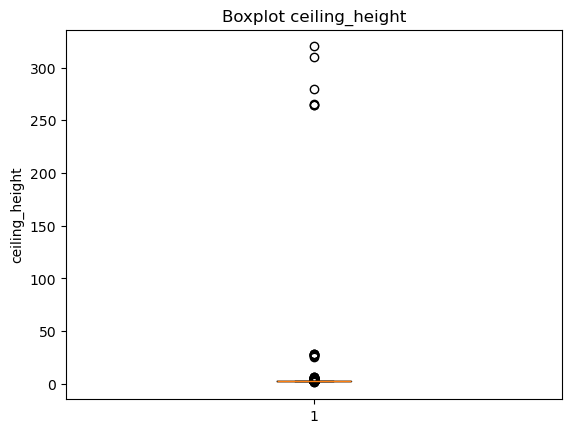

In [223]:
# рассмотрим распределение значений в столбце `ceiling_height` и построим `boxplot`
print(df['ceiling_height'].describe())
plt.boxplot(df['ceiling_height'].dropna())
plt.title('Boxplot ceiling_height')
plt.ylabel('ceiling_height')
plt.show();

In [224]:
# постараемся найти значения, выходящие за рамки логически возможных
df.query('ceiling_height > 5 or ceiling_height < 2')['ceiling_height'].unique().tolist()

[310.0, 28.0, 264.0, 27.0, 26.0, 6.0, 265.0, 320.0, 25.0, 280.0, 1.2]

In [225]:
# заменим ошибочно введенные данные на верные
replace_dict = {
    310.0: 3.1,
    28.0: 2.8,
    264.0: 2.64,
    27.0: 2.7,
    26.0: 2.6,
    265.0: 2.65,
    320.0: 3.2,
    25.0: 2.5,
    280.0: 2.8
}

df['ceiling_height'] = df['ceiling_height'].replace(replace_dict)

# удалим 5 строк с аномальными значениями
df = df[(df['ceiling_height'] <= 5) & (df['ceiling_height'] >= 2)]

In [ ]:
# 
df = df.query('total_area < 300')

89


,id,rooms,type,metro_station,address,area,building_type,parking,price,phones,description,renovation,ceiling_height,listing_url,num_rooms,time_to_metro,total_area,floor,total_floors,parking_categories,main_price,deposit,utilities_included,rental_term,prepayment_months,presence_balcony,numbers_toilets,kids_allowed,pets_allowed,furniture,fridge,washing_machine,condi,fur_in_kitch,elevator_num
30,267489303,6,Квартира,м. Арбатская (5 мин пешком),"Москва, переулок Романов, 5",380.0/250.0/28.0,"3/6, старый фонд",открытая,"870000.0 руб./ За месяц, Залог - 870000 руб., ...",+79850608590,Лот 77779. Елена Анисимова.\n\nБонус агенту 50...,Косметический,4.00,https://www.cian.ru/rent/flat/267489303,6,5.0,380.0,3,6,3,870000.0,870000.0,1,Длительный,1,0,3,1,1,0,1,1,1,1,1
101,271305644,6,Квартира,м. Арбатская (12 мин пешком),"Москва, Большой Николопесковский переулок, 13",336.0,4/5,нет,"590000.0 руб./ За месяц, Залог - 590000 руб., ...",+79099986857,ID 168. С коллегами работаем 50/50. Двухуровне...,Дизайнерский,2.64,https://www.cian.ru/rent/flat/271305644,6,12.0,336.0,4,5,1,590000.0,590000.0,0,Длительный,1,0,1,1,1,0,1,0,0,1,0
137,267915862,6,Квартира,м. Смоленская (5 мин пешком),"Москва, Большой Николопесковский переулок, 13",336.0/270.0/36.0,"4/4, Кирпичный",нет,"590000.0 руб./ За месяц, Залог - 590000 руб., ...","+79152972995, +79651454322",ID 3842. Елена. ПРЯМОЙ ПРЕДСТАВИТЕЛЬ СОБСТВЕНН...,Дизайнерский,2.64,https://www.cian.ru/rent/flat/267915862,6,5.0,336.0,4,4,1,590000.0,590000.0,1,Длительный,1,0,4,1,1,0,1,1,0,1,1
138,273687210,6,Квартира,м. Александровский сад (4 мин пешком),"Москва, переулок Романов, 5",380.0/223.0/43.0,5/5,нет,"650000.0 руб./ За месяц, Залог - 650000 руб., ...",+79652883064,Лот 41840. После ремонта.Без комиссии для арен...,Евроремонт,2.64,https://www.cian.ru/rent/flat/273687210,6,4.0,380.0,5,5,1,650000.0,650000.0,0,Длительный,1,0,3,1,1,1,1,1,1,1,1
197,267743247,"6, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, Большой Николопесковский переулок, 13",336.0/180.0/33.0,4/4,наземная,"590000.0 руб./ За месяц, Залог - 590000 руб., ...","+79672086536, +79099269384","ID 22639: 2-уровневый пентхаус площадью 336,4...",Евроремонт,3.20,https://www.cian.ru/rent/flat/267743247,6,7.0,336.0,4,4,2,590000.0,590000.0,0,Длительный,1,0,4,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23136,274159085,"6, Оба варианта",Квартира,м. Сокол (10 мин на машине),"Москва, Береговая улица, 4К4",360.0/175.0/25.0,6/7,подземная,"650000.0 руб./ За месяц, Залог - 650000 руб., ...","+79670394749, +79099269384",ID 26509: Предлагается современная трехуровне...,Евроремонт,3.20,https://www.cian.ru/rent/flat/274159085,6,10.0,360.0,6,7,0,650000.0,650000.0,0,Длительный,1,0,4,1,0,0,1,1,1,1,1
23137,271497271,"5, Изолированная",Квартира,м. Водный стадион (38 мин пешком),"Москва, Береговая улица, 4К5",320.0/180.0,"4/6, Монолитный",подземная,"700000.0 руб./ За месяц, Залог - 700000 руб., ...","+79652157469, +79672766119",Агенту наибольший бонус! Сдаётся впервые шикар...,Дизайнерский,3.00,https://www.cian.ru/rent/flat/271497271,5,38.0,320.0,4,6,0,700000.0,700000.0,1,Длительный,1,1,3,1,0,1,1,1,1,1,1
23141,229232386,6,Квартира,м. Сокол (9 мин на машине),"Москва, Иваньковское шоссе, 5",800.0/490.0/20.0,"23/24, Монолитно-кирпичный",подземная,"22000.0 $/ За месяц, Залог - 22000 $, Коммунал...","+79152972995, +79651454322",Лот 38410. ЖК АЛИСА. Предлагается в аренду мно...,Дизайнерский,2.64,https://www.cian.ru/rent/flat/229232386,6,9.0,800.0,23,24,0,22000.0,22000.0,1,Длительный,1,1,4,1,1,1,1,1,0,1,4
23142,224335697,6,Квартира,м. Сокол (8 мин на машине),"Москва, Иваньковское шоссе, 5",800.0/640.0,23/23,нет,"23000.0 $/ За месяц, Залог - 23000 $, Коммунал...",+79651074479,Лот: 32563. Екатерина. БОНУС! Вашему внимани...,Евроремонт,2.64,https://www.cian.ru/rent/flat/224335697,6,8.0,800.0,23,23,1,23000.0,23000.0,1,Длительный,1,1,4,1,1,1,1,1,1,1,0


In [227]:
df.describe()

,id,ceiling_height,num_rooms,time_to_metro,total_area,floor,total_floors,parking_categories,main_price,deposit,utilities_included,prepayment_months,presence_balcony,numbers_toilets,kids_allowed,pets_allowed,furniture,fridge,washing_machine,condi,fur_in_kitch,elevator_num
count,1.586200e+04,15862.000000,15862.0,15862.000000,15862.000000,15862.0,15862.0,15862.000000,1.586200e+04,1.586200e+04,15862.000000,15862.0,15862.000000,15862.000000,15862.000000,15862.000000,15862.000000,15862.000000,15862.000000,15862.000000,15862.000000,15862.0
mean,2.660350e+08,2.692540,2.013176,9.707225,64.136783,7.504224,14.376939,1.281616,8.578593e+04,6.991109e+05,0.897239,1.004728,0.694427,1.197327,0.991426,0.566511,0.943198,0.982915,0.972072,0.420439,0.973269,1.630122
std,2.138644e+07,0.177032,1.000607,6.265697,47.971543,5.889946,8.886138,0.721953,1.244208e+05,7.765099e+07,0.303656,0.259811,0.460664,0.514120,0.092201,0.495572,0.231472,0.129592,0.164773,0.493645,0.161300,1.435254
min,1.072986e+08,2.100000,1.0,0.000000,7.000000,1.0,1.0,0.000000,5.000000e+03,0.000000e+00,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,2.708260e+08,2.640000,1.0,5.000000,39.000000,3.0,9.0,1.000000,3.900000e+04,3.500000e+04,1.000000,1.0,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.0
50%,2.739376e+08,2.640000,2.0,9.000000,50.000000,6.0,12.0,1.000000,5.000000e+04,4.700000e+04,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.0
75%,2.747162e+08,2.640000,3.0,13.000000,70.000000,10.0,17.0,2.000000,7.500000e+04,7.500000e+04,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
max,2.750064e+08,5.000000,6.0,119.000000,811.000000,85.0,116.0,5.000000,3.000000e+06,9.779779e+09,1.000000,12.0,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.0
